In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print("Invalid device or cannot modify virtual devices once initialized.")
    pass

In [3]:
htr = pd.read_csv("handwrittentext.csv")

In [4]:
def truncateLabel(text):
    # ctc_loss can't compute loss if it cannot find a mapping between text label and input
    # labels. Repeat letters cost double because of the blank symbol needing to be inserted.
    # If a too-long label is provided, ctc_loss returns an infinite gradient
    maxTextLen = 25
    cost = 0
    for i in range(len(text)):
        if i != 0 and text[i] == text[i - 1]:
            cost += 2
        else:
            cost += 1
        if cost > maxTextLen:
            return text[:i]
    return text

In [5]:
htr["Text"] = htr["Text"].apply(truncateLabel)

In [6]:
images = htr["Image Location"].values.tolist()
labels = htr["Text"].values.tolist()
characters = set(char for label in labels for char in label)
characters = [char for char in characters]

In [7]:
# Image dimensions
img_width = 200
img_height = 50

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 3.
# Hence total downsampling factor would be 8.
downsample_factor = 8

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

In [8]:
char_to_num = {"": 0}
c = 1
for i in characters:
    char_to_num[i] = c
    c += 1
    
num_to_char = {value:key for key,value in char_to_num.items()}

In [9]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels = 1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm = [1, 0, 2])
    label = [char_to_num[i] for i in label]
    label = label + [0]*(max_length - len(label))
    return {"image": img.numpy(), "label": label}

def split_data(images, labels, train_size = 0.9, shuffle = True):
    size = len(htr)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train = np.zeros((train_samples,) + (img_width, img_height,) + (1,), dtype = "float32")
    y_train = np.zeros((train_samples, max_length,), dtype = "int64")
    x_valid = np.zeros((size - train_samples,) + (img_width, img_height,) + (1,), dtype = "float32")
    y_valid = np.zeros((size - train_samples, max_length,), dtype = "int64")
    
    for i,j,k in tqdm(zip(range(train_samples), images[indices[:train_samples]], \
                          labels[indices[:train_samples]]), total = train_samples):
        sample = encode_single_sample(j,k)
        x_train[i] = sample["image"]
        y_train[i] = sample["label"]
    for i,j,k in tqdm(zip(range(size - train_samples), images[indices[train_samples:]], \
                        labels[indices[train_samples:]]), total = size - train_samples):
        sample = encode_single_sample(j,k)
        x_valid[i] = sample["image"]
        y_valid[i] = sample["label"]
    return x_train, x_valid, y_train, y_valid


# Splitting data into training and validation sets
x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))

100%|██████████| 2905/2905 [00:09<00:00, 303.06it/s]


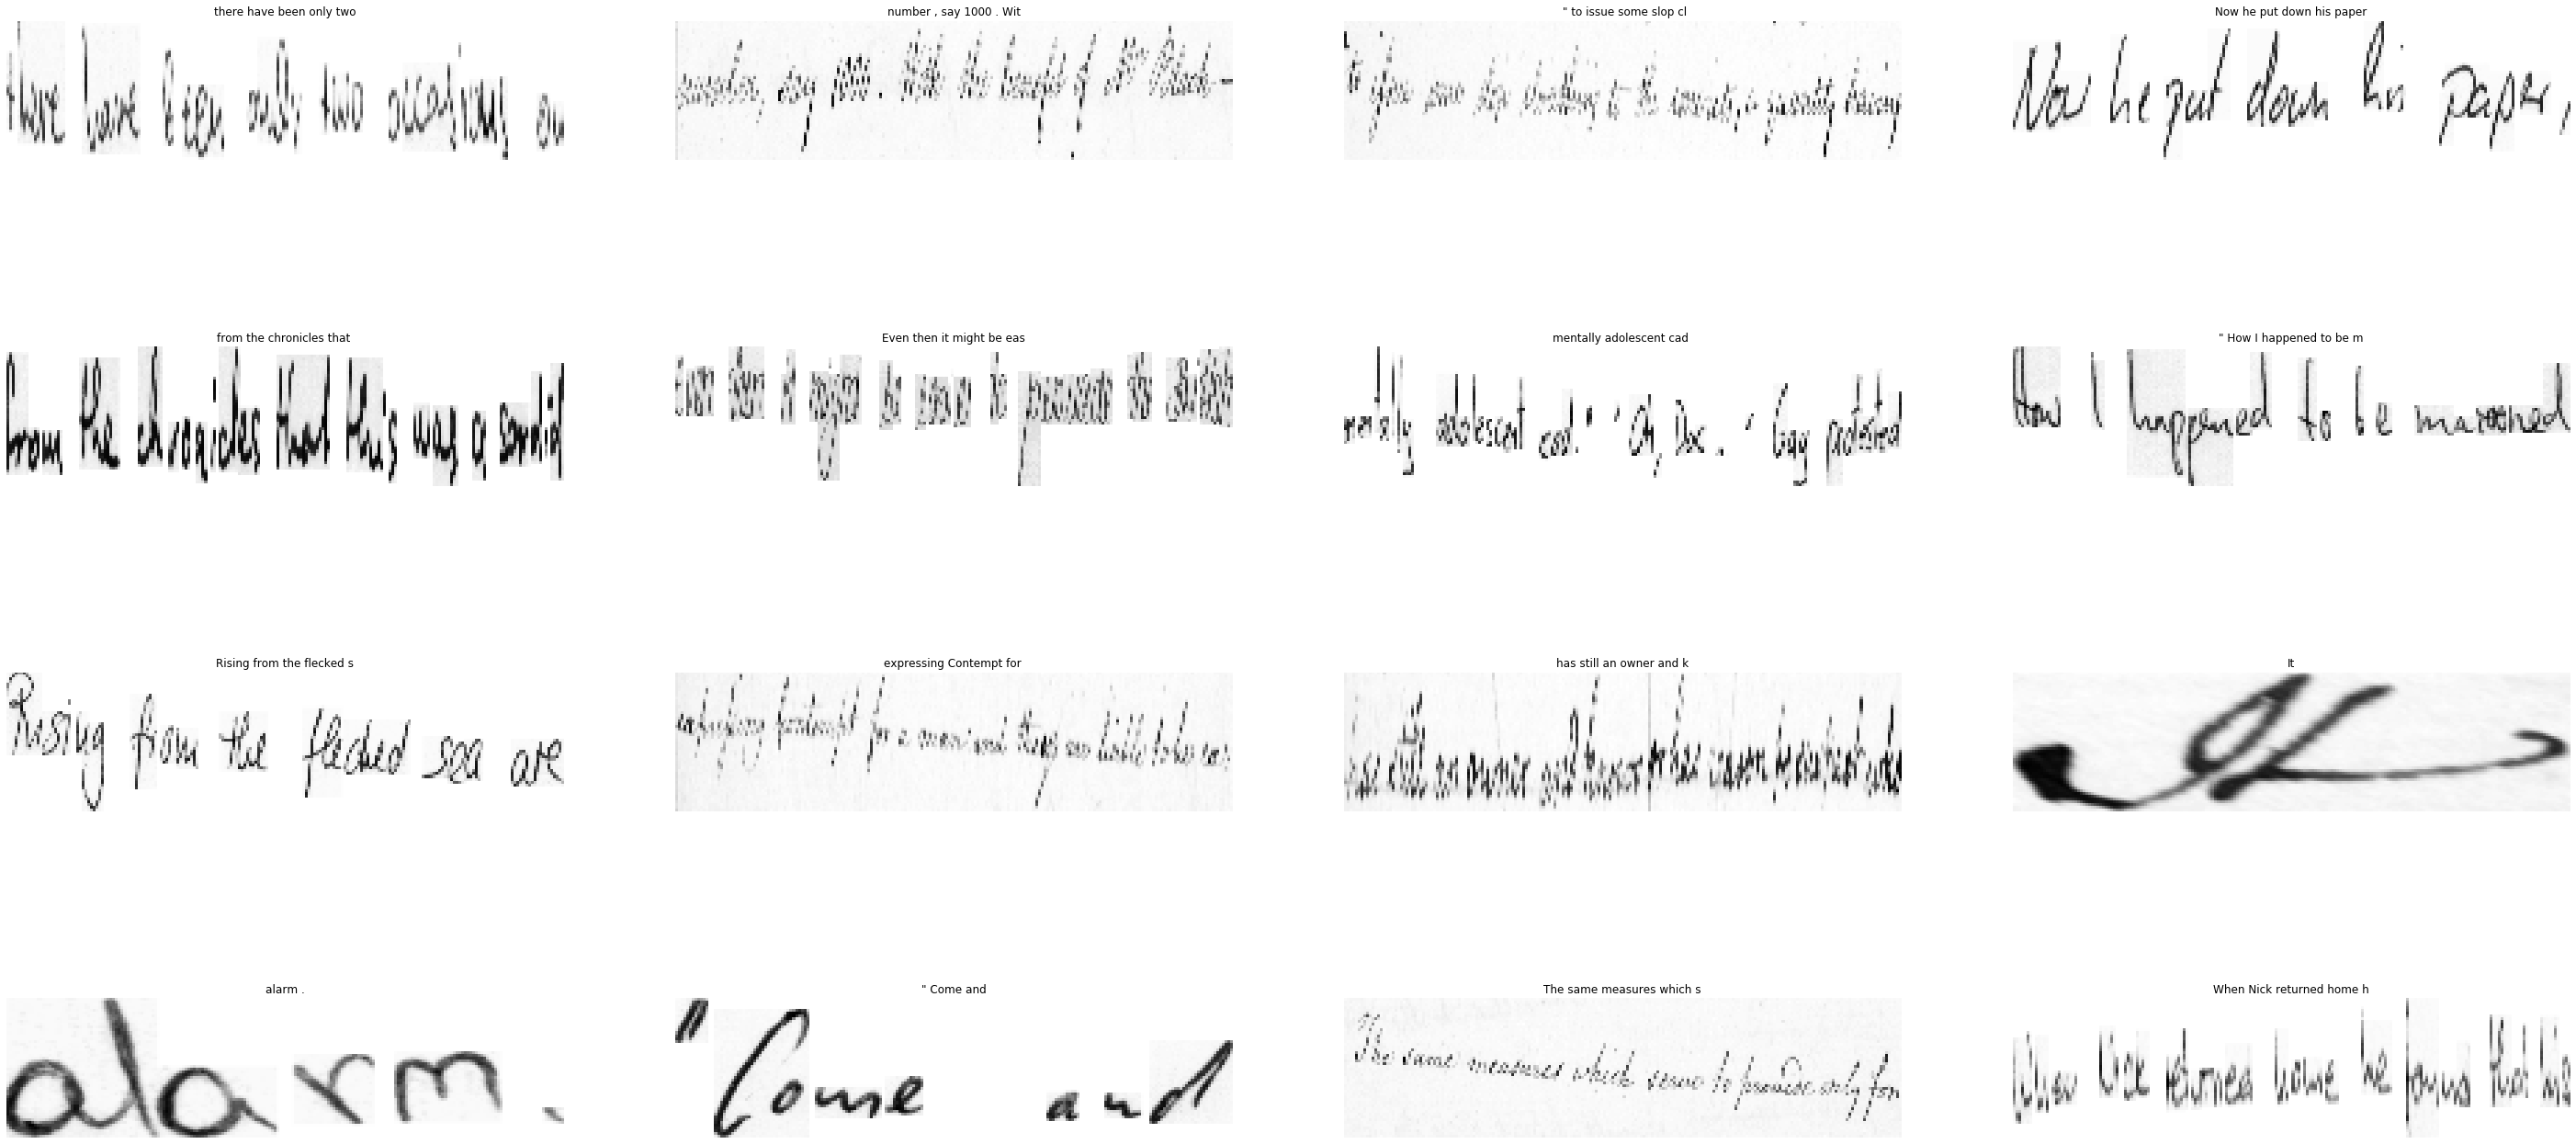

In [10]:
_, ax = plt.subplots(4, 4, figsize = (50, 25))
for i, image, text in zip(range(16), x_train[:16], y_train[:16]):
    img = (image * 255).astype("uint8")
    label = "".join([num_to_char[i] for i in text])
    ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap = "gray")
    ax[i // 4, i % 4].set_title(label)
    ax[i // 4, i % 4].axis("off")
plt.show()

In [11]:
class CTCLayer(layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")

        input_length = input_length * tf.ones(shape = (batch_len, 1), dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 1), dtype = "int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape = (img_width, img_height, 1), name = "image", dtype = "float32"
    )
    labels = layers.Input(name = "label", shape = (None,), dtype = "float32")

    # First conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name = "pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        128,
        (3, 3),
        activation = "relu",
        kernel_initializer = "he_normal",
        padding = "same",
        name = "Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name = "pool2")(x)
    

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    x = layers.Reshape(target_shape = new_shape, name = "reshape")(x)
    x = layers.Dense(128, activation = "relu", name = "dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True))(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences = True))(x)
    x = layers.Dropout(0.25)(x)
    
    # Output layer
    x = layers.Dense(len(num_to_char) + 1, activation = "softmax", name = "dense2")(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name = "ctc_loss")(labels, x)

    # Define the model
    model = tf.keras.models.Model(
        inputs = [input_img, labels], outputs = output, name = "ocr_model_v1"
    )
    # Optimizer
    opt = tf.keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer = opt)
    return model


# Get the model
model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 200, 50, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 200, 50, 64)  640         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 100, 25, 64)  0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 100, 25, 128) 73856       pool1[0][0]                      
_______________________________________________________________________________________

In [12]:
epochs = 100
early_stopping_patience = 10

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor = "val_loss", patience = early_stopping_patience, restore_best_weights = True
)

history = model.fit(
    [x_train, y_train],
    validation_data = ([x_valid, y_valid]),
    epochs = epochs,
    callbacks = [early_stopping],
    batch_size = 16
)

Epoch 1/100
1634/1634 [==============================] - 63s 39ms/step - loss: 74.8009 - val_loss: 68.7935
Epoch 2/100
1634/1634 [==============================] - 53s 32ms/step - loss: 66.2374 - val_loss: 61.8153
Epoch 3/100
1634/1634 [==============================] - 53s 32ms/step - loss: 61.2810 - val_loss: 57.8379
Epoch 4/100
1634/1634 [==============================] - 53s 32ms/step - loss: 58.1535 - val_loss: 55.0244
Epoch 5/100
1634/1634 [==============================] - 59s 36ms/step - loss: 55.9661 - val_loss: 52.9983
Epoch 6/100
1634/1634 [==============================] - 54s 33ms/step - loss: 54.1402 - val_loss: 51.4191
Epoch 7/100
1634/1634 [==============================] - 59s 36ms/step - loss: 52.6647 - val_loss: 50.7092
Epoch 8/100
1634/1634 [==============================] - 54s 33ms/step - loss: 51.5007 - val_loss: 48.2598
Epoch 9/100
1634/1634 [==============================] - 59s 36ms/step - loss: 50.4181 - val_loss: 48.2213
Epoch 10/100
1634/1634 [=============

Epoch 77/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.3583 - val_loss: 37.8906
Epoch 78/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.2526 - val_loss: 38.8343
Epoch 79/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.1813 - val_loss: 38.0895
Epoch 80/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.1771 - val_loss: 37.9384
Epoch 81/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.2024 - val_loss: 38.1375
Epoch 82/100
1634/1634 [==============================] - 53s 32ms/step - loss: 35.9962 - val_loss: 38.6669
Epoch 83/100
1634/1634 [==============================] - 53s 32ms/step - loss: 36.0716 - val_loss: 37.9719
Epoch 84/100
1634/1634 [==============================] - 53s 32ms/step - loss: 35.8320 - val_loss: 38.4622
Epoch 85/100
1634/1634 [==============================] - 53s 32ms/step - loss: 35.9199 - val_loss: 38.5049
Epoch 86/100
1634/1634 [====

In [13]:
prediction_model = keras.models.Model(
    model.get_layer(name = "image").input, model.get_layer(name = "dense2").output
)
prediction_model.summary()

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length = input_len, greedy = True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    return("".join([num_to_char[i] for i in results.numpy()[0] if i > -1]))

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 200, 50, 1)]      0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 200, 50, 64)       640       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 100, 25, 64)       0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 100, 25, 128)      73856     
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 50, 12, 128)       0         
_________________________________________________________________
reshape (Reshape)            (None, 50, 1536)          0         
_________________________________________________________________
dense1 (Dense)               (None, 50, 128)          

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


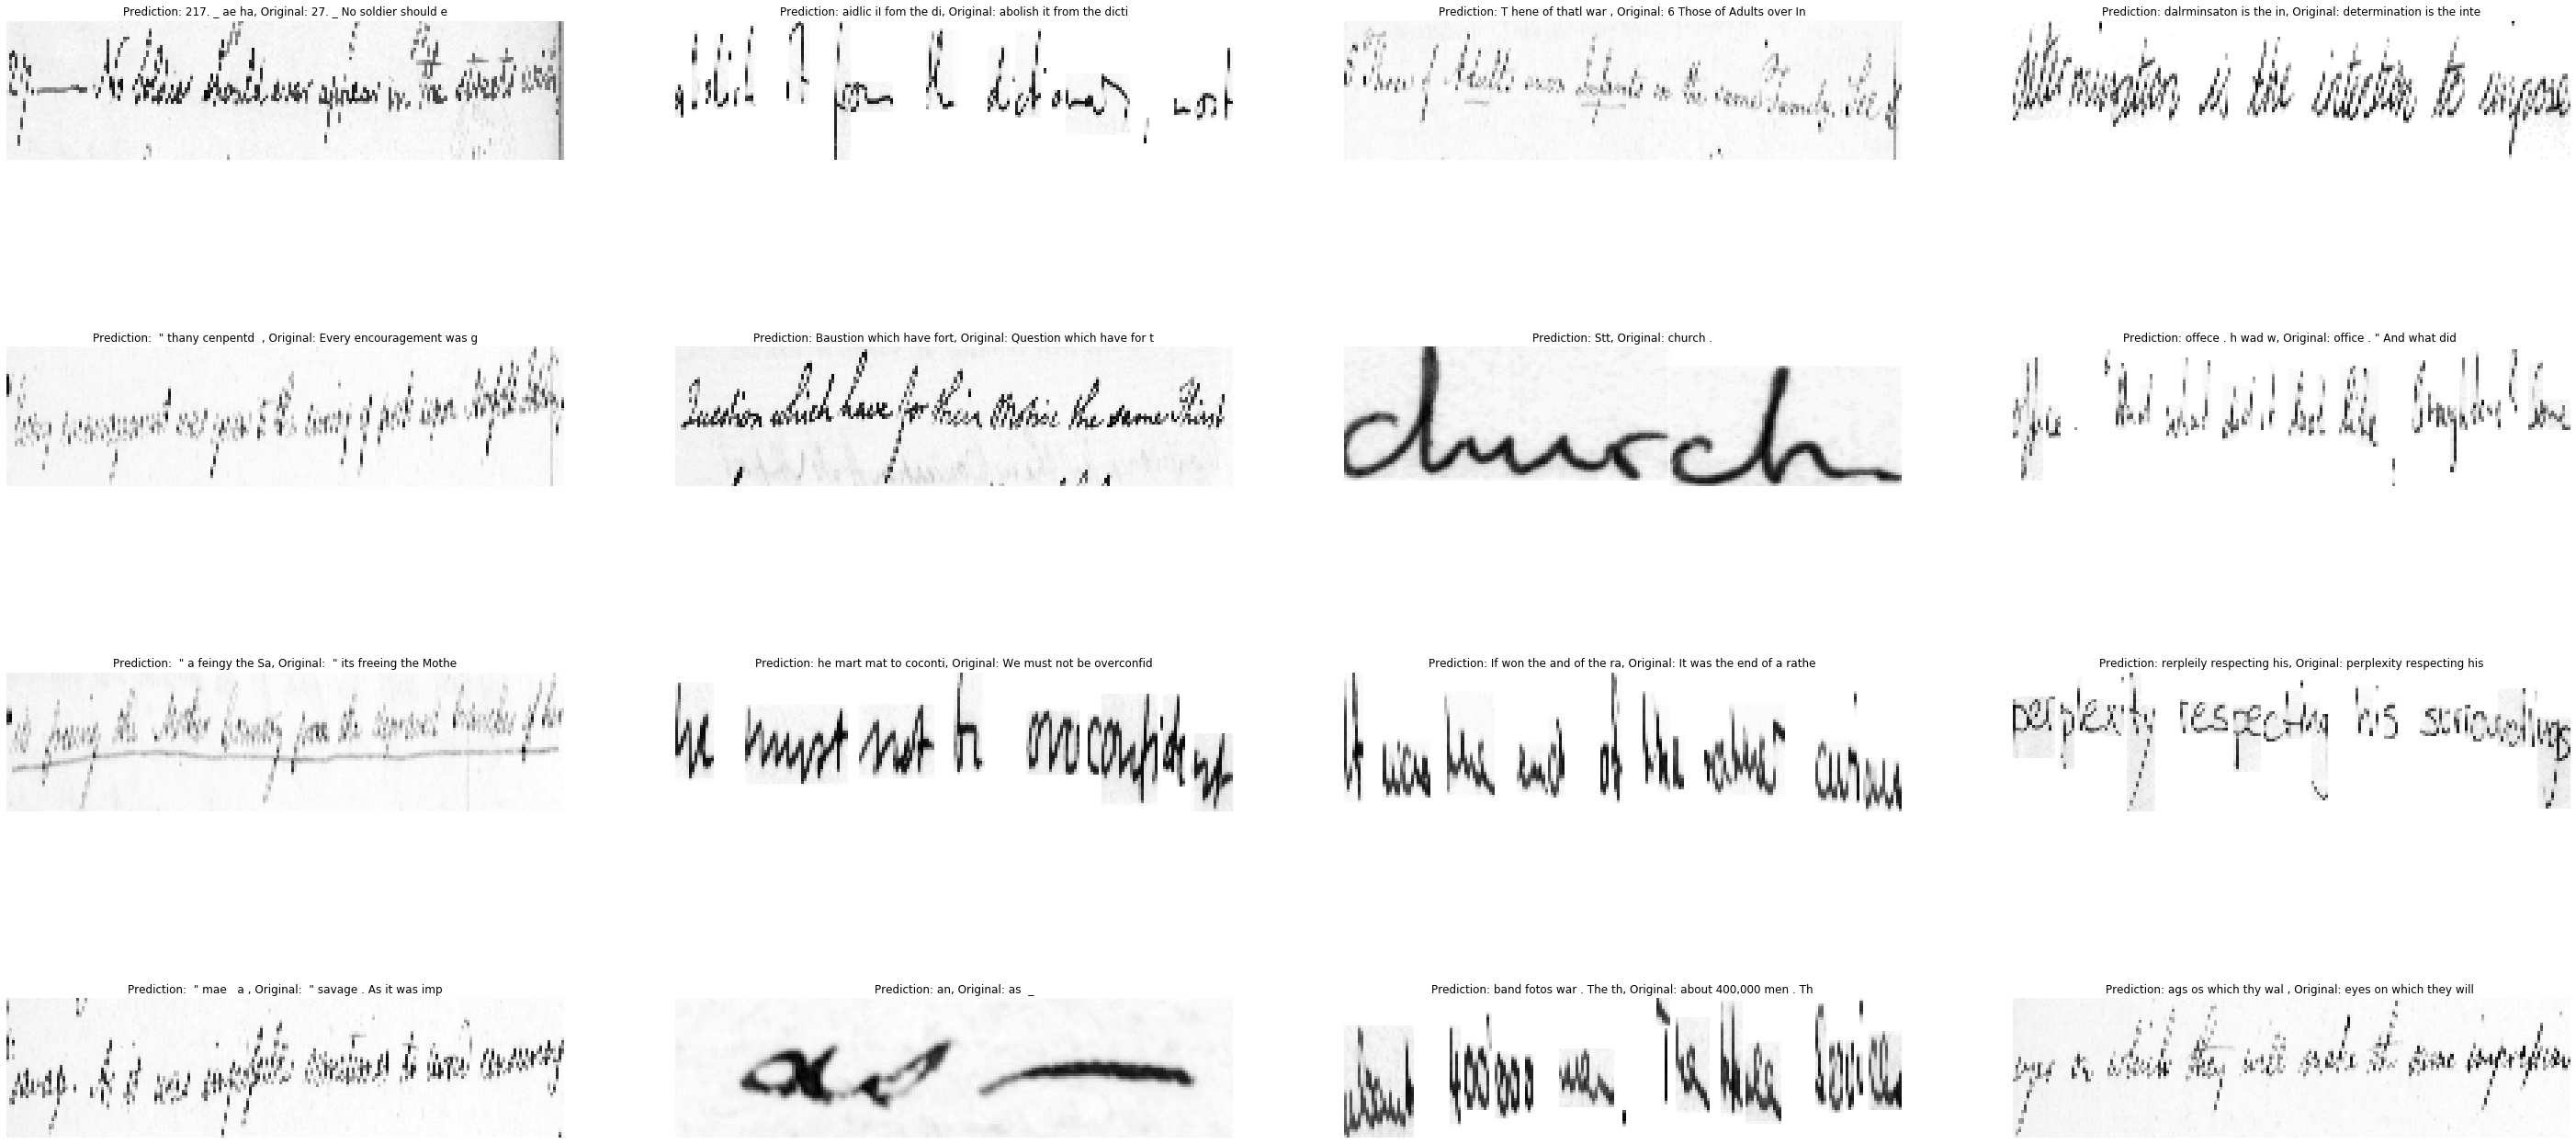

In [14]:
#  Let's check results on some validation samples
_, ax = plt.subplots(4, 4, figsize = (50, 25))
for i, image, text in zip(range(16), x_valid[:16], y_valid[:16]):

    preds = prediction_model.predict(np.expand_dims(image, axis = 0))
    pred_texts = decode_batch_predictions(preds)

    label = "".join([num_to_char[i] for i in text])

    img = (image * 255).astype(np.uint8)
    img = img[:, :, 0].T
    title = f"Prediction: {pred_texts}, Original: {label}"
    ax[i // 4, i % 4].imshow(img, cmap = "gray")
    ax[i // 4, i % 4].set_title(title)
    ax[i // 4, i % 4].axis("off")
plt.show()